# Callin Switzer
### 29 Jan 2020


# Make videos of moth "flying"

___

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as colors
from  mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib
import pickle
import numpy as np
import os
import math
import seaborn as sns
from scipy.integrate import odeint
import random
import time
from datetime import datetime
from matplotlib.patches import Ellipse
from matplotlib.patches import Arc
from collections import OrderedDict
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import sys
import pandas as pd
import importlib
import numba

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
else: 
    print("tensorflow using CPU")
    
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers
from keras.models import load_model

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

# import simUtils -- a custom python script from the GenerateData folder
sys.path.insert(1, r"../GenerateData/")
import simUtils_one_torque as simUtils

print(sys.version)
now = datetime.now()
print("last run on " + str(now))

TensorFlow successfully installed.
tensorflow using CPU


Using TensorFlow backend.


3.6.4 |Anaconda custom (64-bit)| (default, Jan 16 2018, 10:22:32) [MSC v.1900 64 bit (AMD64)]
last run on 2020-01-29 16:16:41.700939


In [2]:
# make sure Keras uses CPU instead of GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# define directories
baseDir = os.getcwd()
figDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs'
dataOutput = r'D:/Dropbox/AcademiaDropbox/mothMachineLearning_dataAndFigs/dataoutput/'
savedModels = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels'
dataDir = r'D:/Dropbox/AcademiaDropbox/mothMachineLearning_dataAndFigs/PythonGeneratedData_oneTorque/'
if not os.path.exists(figDir):
    os.mkdir(figDir)
if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)


In [3]:
# define some functions

def cart2pol(x, y):
    '''Cartesian to polar coordinates'''
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(radius, phi):
    '''
    Polar to Cartesian coordinates
        radius: radius
        phi: angle (in radians)
    '''
    x = radius * np.cos(phi)
    y = radius * np.sin(phi)
    return(x, y)

def midpoint(p1, p2):
    return ((p1[0]+p2[0])/2, (p1[1]+p2[1])/2)

def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

def angleCalc(Fx, Fy):
    alpha = np.arctan2(Fy, Fx)
    return(alpha)

def F_alpha_calc (Fx, Fy):
    alpha = angleCalc(Fx, Fy)
    F = np.sqrt(Fx**2 + Fy**2)
    return(F, alpha)


In [4]:
globalDict = OrderedDict({
            "bhead": 0.5,
            "ahead": 0.9,
            "bbutt": 0.75,
            "abutt": 1.9, 
            "rho_head": 0.9,
            "rho_butt": 0.4,
            "rhoA": 0.00118, 
            "muA": 0.000186, 
            "L1": 0.9, 
            "L2": 1.9,  
            "L3": 0.75,
            "K": 23000,
            "c":  14075.8,
            "g": 980.0,
            "betaR":  0.0,
            "nstep": 50, # return start and endpoints
            "nrun" : 100 # (max) number of  trajectories.
            })

# Calculated variables
globalDict['m1'] = globalDict['rho_head']*(4/3)*np.pi*(globalDict['bhead']**2)*globalDict['ahead']
globalDict["m2"] = globalDict["rho_butt"]*(4/3)*np.pi*(globalDict["bbutt"]**2)*globalDict["abutt"]
globalDict["echead"] = globalDict["ahead"]/globalDict["bhead"]
globalDict['ecbutt'] = globalDict['abutt']/globalDict['bbutt']
globalDict['I1'] = (1/5)*globalDict['m1']*(globalDict['bhead']**2)*(1 + globalDict['echead']**2)
globalDict['I2'] = (1/5)*globalDict['m2']*(globalDict['bbutt']**2)*(1 + globalDict['ecbutt']**2)
globalDict['S_head'] = np.pi*globalDict['bhead']**2
globalDict['S_butt'] = np.pi*globalDict['bbutt'] **2
t = np.linspace(0, 0.02, num = globalDict["nstep"], endpoint = True)

# convert dict to list, since @jit works better with lists
globalList = [ v for v in globalDict.values() ]


# ranges for control variables
rangeDict = {"Fmin": 0,
             "Fmax": 44300,
             "alphaMin":  0,
             "alphaMax":2*np.pi, 
             "tau0Min": -100000, 
             "tau0Max": 100000}

# ranges for controls 
ranges = np.array([[rangeDict["Fmin"], rangeDict["Fmax"]], 
                   [rangeDict["alphaMin"], rangeDict["alphaMax"]], 
                   [rangeDict["tau0Min"], rangeDict["tau0Max"] ]])

# ranges for initial conditions
IC_ranges = np.array([[0, 0],        #x
                      [-1500, 1500], #xdot  
                      [0, 0],        #y
                      [-1500, 1500], #ydot
                      [0, 2*np.pi],  #theta
                      [-25, 25],     #theta dot
                      [0, 2*np.pi],  #phi
                      [-25, 25]])    # phi dot

In [5]:
# plot moth at certain timesteps
# plot final positions
def plotMoth(x,y,theta, phi, F, alpha, tau0, fig, ax):
    # plot moth and force
    thoraxLen = globalDict["ahead"]*2 # cm
    abLen = globalDict["abutt"]*2 #cm
    thoraxWidth = globalDict["bhead"]*2
    abWidth = globalDict["bbutt"]*2

    # plot trajectory
    ax.set_aspect('equal', 'datalim')
      
    center = np.array([x, y])
    head = center + np.array(pol2cart(thoraxLen, theta))
    abTip = center + np.array(pol2cart(abLen, phi))

    xx, yy = zip(*[center, head])
    xab,yab = zip(*[center, abTip])

    el = Ellipse(midpoint(center, head), width = thoraxLen, 
                 height = thoraxWidth, facecolor='#907760', 
                 alpha=0.9, angle = math.degrees(theta))
    el2 = Ellipse(midpoint(center, abTip), width = abLen, 
                  height = abWidth, facecolor='#DEC9B0', 
                  alpha=0.9, angle = math.degrees(phi))    
  
    ax.add_artist(el)
    ax.add_artist(el2)

    ax.plot(*center, 'o', color = "#B61212", alpha = 0.9)
    ax.plot(*midpoint(center, head), marker=r'o', 
            markersize=10, markeredgewidth=0.2, 
            color = '#444444', alpha = 0.9)
    ax.plot(*midpoint(center, abTip), marker=r'o', 
            markersize=10, markeredgewidth=0.2, 
            color = "black", alpha = 0.9)
    ax.plot(xab,yab, 'k', alpha = 0.2)
    ax.plot(xx, yy, 'k', alpha = 0.2)
    
    # plot force 
    forceAlpha = alpha
    forceCenter = center + pol2cart(globalDict["L3"], theta)
    forceMagnitude = F / 150000 # scale 
    forceAngle = theta + forceAlpha
    forceTip = np.add(pol2cart(forceMagnitude, forceAngle), forceCenter)
    ax.arrow(x = forceCenter[0], y = forceCenter[1], 
             dx = forceTip[0] - forceCenter[0],  dy =  forceTip[1] - forceCenter[1], 
            head_width = 0.2, color = "#B61212")

    if tau0 >= 0:
        arrowDirection = pol2cart(0.01, theta + 1 + np.pi/2)
        ax.arrow(*(center + (np.cos(theta + 1)*0.5, np.sin(theta + 1)*0.5)), 
                 *arrowDirection, 
                head_width = 0.2, color = "#B61212")
        arrowDirection_b = pol2cart(0.01, phi - 1 - np.pi/2 )
        ax.arrow(*(center + pol2cart(0.5, phi-1)),
                 *arrowDirection_b, 
                head_width = 0.2, color = "#B61212")

    else:
        arrowDirection = pol2cart(0.01, theta - 1 - np.pi/2)
        ax.arrow(*(center + (np.cos(theta - 1)*0.5, np.sin(theta - 1)*0.5)), 
                 *arrowDirection, 
                head_width = 0.2, color = "#B61212")

        arrowDirection_b = pol2cart(0.01, phi + 1 + np.pi/2 )
        ax.arrow(*(center + pol2cart(0.5, phi+1)),
                 *arrowDirection_b, 
                head_width = 0.2, color = "#B61212")

#     add torque arrow
    torqueArc = Arc([x,y], 1, 1, angle=0.0, 
                    theta1= np.degrees(theta- 1), 
                    theta2=np.degrees(theta+1), color = "#B61212")
    ax.add_artist(torqueArc)
        
    torqueArc_b = Arc([x,y], 1, 1, angle=0.0, 
                      theta1= np.degrees(phi-1), 
                      theta2=np.degrees(phi + 1), color = "#B61212")
    ax.add_artist(torqueArc_b)



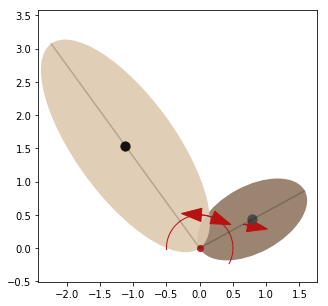

In [6]:
# example moth plot
fig, ax = plt.subplots(figsize = [5, 5])
plotMoth(0, 0, 0.5, .7*np.pi, 10000, -0.7, +1, fig, ax)

In [7]:
# x,xd,y,yd,theta,thetad,phi,phid
state0_ICs = [[0.0, 0.0005, 0.0, 0.000000001, np.pi/2, 0.0000001, 3*np.pi/2, 0.000001]]

F = 100000
alpha = np.pi / 2
tau0 = -1000000

FAlphaTau_list = [[F, alpha, tau0]]
x, xd, y, yd, theta, thetad, phi, phid = simUtils.flyBug_listInput_oneTorque(0, t, state0_ICs, FAlphaTau_list, globalList)

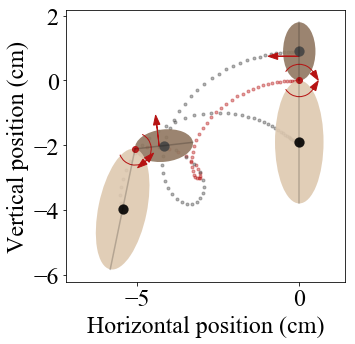

In [8]:
plt.rc('font',family='Times New Roman')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.default'] = 'regular'
plt.rcParams.update({'font.size': 24})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42



def plot_moth_trajectory(x, y, theta, phi, F, alpha, tau0, fig, ax):
   
    for ii in np.linspace(0, len(x)-1, num = 2, endpoint = True, dtype = "int"):
        plotMoth(x[ii], y[ii], theta[ii], phi[ii], F, alpha, tau0, fig, ax)


    # plot moth and force
    thoraxLen = globalDict["ahead"]*2 # cm
    abLen = globalDict["abutt"]*2 #cm
    thoraxWidth = globalDict["bhead"]*2
    abWidth = globalDict["bbutt"]*2
    
    center = np.array([x, y])
    head = center + np.array(pol2cart(thoraxLen, theta))
    abTip = center + np.array(pol2cart(abLen, phi))
    headCenterx, headCentery = midpoint(center, head)
    abCenterx, abCentery = midpoint(center, abTip)

    for ii in np.arange(0, len(x), 1):
        ax.scatter(x[ii], y[ii], marker = ".", color = "#B61212", alpha = 0.4)
        ax.scatter(headCenterx[ii], headCentery[ii], marker = ".", color = '#444444', alpha = 0.4)
        ax.scatter(abCenterx[ii], abCentery[ii], marker = ".", color = '#444444', alpha = 0.4)
    ax.set_xlabel("Horizontal position (cm)")
    ax.set_ylabel("Vertical position (cm)")
    
fig, ax = plt.subplots(figsize = [5, 5])
plot_moth_trajectory(x, y, theta, phi, F, alpha, tau0, fig, ax)    
fig.savefig(os.path.join(figDir, "MothPath1.pdf"), bbox_inches='tight')
plt.show()

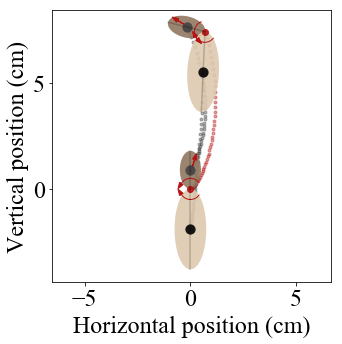

In [9]:
# x,xd,y,yd,theta,thetad,phi,phid
state0_ICs = [[0.0, 0.0005, 0.0, 0.000000001, np.pi/2, 0.0000001, 3*np.pi/2, 0.000001]]


F = 100000
alpha = -0.3
tau0 = 1000000

FAlphaTau_list = [[F, alpha, tau0]]
x, xd, y, yd, theta, thetad, phi, phid = simUtils.flyBug_listInput_oneTorque(0, t, state0_ICs, FAlphaTau_list, globalList)
fig, ax = plt.subplots(figsize = [5, 5])
plot_moth_trajectory(x, y, theta, phi, F, alpha, tau0, fig, ax)    
fig.savefig(os.path.join(figDir, "MothPath2.pdf"), bbox_inches='tight')
plt.show()

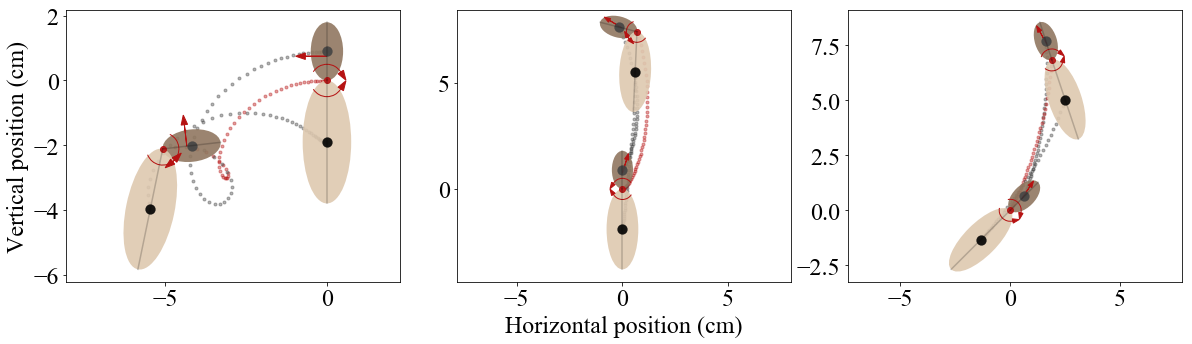

In [10]:
# make into a single plot
fig, axs = plt.subplots(1,3, figsize=np.array([20, 5]), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.1, wspace=.17)
# moth 1
state0_ICs = [[0.0, 0.0005, 0.0, 0.000000001, np.pi/2, 0.0000001, 3*np.pi/2, 0.000001]]
F = 100000
alpha = np.pi / 2
tau0 = -1000000
FAlphaTau_list = [[F, alpha, tau0]]
x, xd, y, yd, theta, thetad, phi, phid = simUtils.flyBug_listInput_oneTorque(0, t, state0_ICs, FAlphaTau_list, globalList)
plot_moth_trajectory(x, y, theta, phi, F, alpha, tau0, fig, axs[0]) 
axs[0].set_xlabel("")



## moth 2
state0_ICs = [[0.0, 0.0005, 0.0, 0.000000001, np.pi/2, 0.0000001, 3*np.pi/2, 0.000001]]
F = 100000
alpha = -0.3
tau0 = 1000000
FAlphaTau_list = [[F, alpha, tau0]]
x, xd, y, yd, theta, thetad, phi, phid = simUtils.flyBug_listInput_oneTorque(0, t, state0_ICs, FAlphaTau_list, globalList)
plot_moth_trajectory(x, y, theta, phi, F, alpha, tau0, fig, axs[1]) 
axs[1].set_ylabel("")

## Moth 3
state0_ICs = [[0.0, 0.0005, 0.0, 0.000000001, np.pi/4, 0.0000001, 5*np.pi/4, 0.000001]]
F = 100000
alpha = +0.2
tau0 = -10000
FAlphaTau_list = [[F, alpha, tau0]]
x, xd, y, yd, theta, thetad, phi, phid = simUtils.flyBug_listInput_oneTorque(0, t, state0_ICs, FAlphaTau_list, globalList)

plot_moth_trajectory(x, y, theta, phi, F, alpha, tau0, fig, axs[2]) 
axs[2].set_ylabel("")
axs[2].set_xlabel("")
fig.savefig(os.path.join(figDir, "MothPaths.pdf"), bbox_inches='tight')
plt.show()



---

In [11]:
# import model and predict

modelPath = r"D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels\Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_01_27__01_30_06.h5"
modeltimestamp = "2020_01_27__01_30_06"
model = load_model(modelPath)


scalerfileX = 'scalerX_fullact_' + modeltimestamp + '.pkl'
scalerX = pickle.load(open(os.path.join(dataOutput, scalerfileX), 'rb'))

scalerfileY = 'scalerY_fullact_' + modeltimestamp + '.pkl'
scalerY = pickle.load(open(os.path.join(dataOutput, scalerfileY), 'rb'))

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               4400      
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                6416      
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 119       
Total params: 331,735
Trainable params: 331,735
Non-trainable params: 0
_________________________________________________________________


In [13]:
#inputData
Xcols = ["phi_0", "theta_0", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0",
                   "x_99", "y_99",  "phi_99",  "theta_99",
                   ]

Ycols = ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99","phi_dot_99","theta_dot_99"]

In [14]:
# convert dict to list, since @jit works better with lists
globalList = [ v for v in globalDict.values() ]
sns.set_style("whitegrid", {'axes.grid' : True})
overallCtr = 1
XYStart = [0,0]

# x,xd,y,yd,theta,thetad,phi,phid
networkInput = OrderedDict({
                        'phi_0':[3*np.pi/2], 
                        'theta_0':[np.pi/2], 
                        'x_dot_0':[0.000001], 
                        'y_dot_0':[0.000001], 
                        'phi_dot_0':[0], 
                        'theta_dot_0':[0], 
                        'x_99':[0], 
                        'y_99':[0], 
                        'phi_99':[3*np.pi/2],
                        'theta_99':[np.pi/2]})

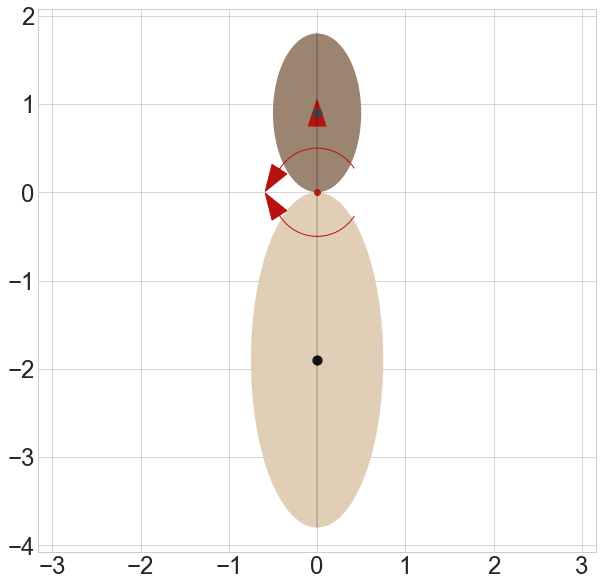

In [15]:
# plot starting position
fig, ax = plt.subplots( figsize = [10,10])
plotMoth(0, 0, networkInput["theta_0"][0], networkInput["phi_0"][0], 0, 0, 0, fig, ax)

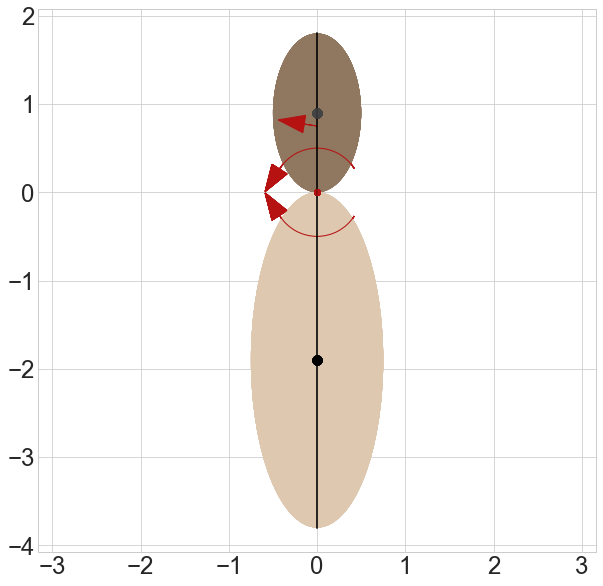

In [16]:
FAlphaTau_list = []
fig, ax = plt.subplots( figsize = [10,10])
for ii in range(10):
    X_scaled = scalerX.transform(np.array([ v[0] for v in networkInput.values() ]).reshape(1, -1))


    # predict
    pred = model.predict(X_scaled)

    # inverse transform
    pred_trans = scalerY.inverse_transform(pred)
    Fx, Fy, tau0, _, _, _, _ = pred_trans[0]
    F, alpha = F_alpha_calc(Fx, Fy)
    FAlphaTau_list.append([F, alpha, tau0])

    
    
    plotMoth(0, 0, networkInput["theta_0"][0], networkInput["phi_0"][0], F, alpha, 1, fig, ax)

In [17]:
networkDF = pd.DataFrame(networkInput)

In [18]:
# make video with pred
# x,xd,y,yd,theta,thetad,phi,phid
state0_ICs = [[0.0, 0.0001, 0.0, 0.0001, np.pi, 0.0001, 0.0, 0.0001]]
state0_ICs

[[0.0, 0.0001, 0.0, 0.0001, 3.141592653589793, 0.0001, 0.0, 0.0001]]

In [19]:
# convert FX, Fy, back to F, alpha
F, alpha = cart2pol(Fx, Fy)


In [20]:
FAlphaTau_list = [[F, alpha, tau0]]
FAlphaTau_list

[[22036.680212986292, 1.4125586, 169346.86]]

In [21]:
x, xd, y, yd, theta, thetad, phi, phid = simUtils.flyBug_listInput_oneTorque(0, t, state0_ICs, FAlphaTau_list, globalList)

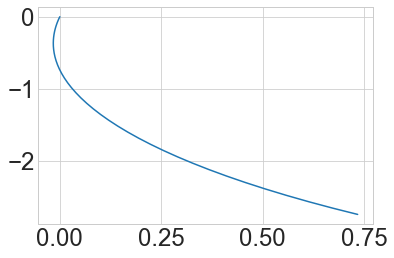

In [22]:
plt.plot(x, y)

___

# Start loop

In [23]:
sns.set_style("whitegrid", {'axes.grid' : True})

overallCtr = 1


# refref: maybe the derivatives should be in the input, so it doesn't go too fast

# define initial position and goal position


# x,xd,y,yd,theta,thetad,phi,phid
where_I_am = OrderedDict({
                        "x_0": [0], 
                        "x_dot_0":[-0.0001], 
                        "y_0":[0], 
                        "y_dot_0": [0.0001]  ,
                        "theta_0": [np.pi/2]  ,
                        "theta_dot_0": [0.0001]  , 
                        "phi_0": [3*np.pi/2 - np.pi/2]   ,
                        "phi_dot_0":[0.0001] })


where_I_want2b = OrderedDict({"x_99": [0],
                              "y_99": [0],
                              "phi_99": [3*np.pi/2],
                              "theta_99": [np.pi/2]})

xList = []
yList = []

prevXY = [where_I_am["x_0"][0], where_I_am["y_0"][0]]

goalXY = [where_I_want2b["x_99"][0], where_I_want2b["y_99"][0]]

In [24]:
inputData =  pd.DataFrame(OrderedDict(list(where_I_am.items()) + list(where_I_want2b.items())))
inputData = inputData.loc[:, Xcols]
#print(inputData)


# predict force needed to attain 
## scale data and transform
X_scaled = scalerX.transform(inputData)


## predict with nnet
pred = model.predict(X_scaled[0, :].reshape(1, -1))

# inverse transform
pred_trans = scalerY.inverse_transform(pred)

pred_trans[0]


array([ -1.53683818e+04,   3.33077812e+04,   1.72037969e+05,
         2.93292114e+02,  -4.47124420e+02,  -1.10078102e+02,
        -1.05378372e+02], dtype=float32)

In [25]:
tmpDir2 = r"C:\Users\calli\Desktop\imgs"
if not os.path.exists(tmpDir2):
    os.mkdir(tmpDir2)

In [26]:
###### start of loop 
###### Note that there may be an error in this code
for jj in range(2):

    inputData =  pd.DataFrame(OrderedDict(list(where_I_am.items()) + list(where_I_want2b.items())))
    inputData = inputData.loc[:, Xcols]

    # predict force needed to attain 
    ## scale data and transform
    X_scaled = scalerX.transform(inputData)
    
    ## predict with nnet
    pred = model.predict(X_scaled[0, :].reshape(1, -1))

    # inverse transform
    pred_trans = scalerY.inverse_transform(pred)
    Fx, Fy, tau0, x_dot_99, y_dot_99, phi_dot_99, theta_dot_99  = pred_trans[0]

    # convert FX, Fy, back to F, alpha
    # F, alpha = cart2pol(Fx, Fy)
    F, alpha = F_alpha_calc(Fx, Fy)

    # plug predictions into simulation
    FAlphaTau_list = [[F, alpha, tau0]]

    # x,xd,y,yd,theta,thetad,phi,phid
    state0_ICs = [[ v[0] for v in where_I_am.values() ]]

    x, xd, y, yd, theta, thetad, phi, phid = simUtils.flyBug_listInput_oneTorque(0, t, state0_ICs, FAlphaTau_list, globalList)

    # add previous position to x and y
    x = x + prevXY[0]
    y = y + prevXY[1]
    
    # plot actual position
    xList.extend(x.tolist())
    yList.extend(y.tolist())

    maxFrms = len(x)

    # refref: add x's to each plot
    for ii in np.arange(0, maxFrms, 1):
        fig, ax = plt.subplots(figsize = [15,15])

        plt.plot(xList[:-(maxFrms-ii)], yList[:-(maxFrms-ii)], c= 'orange', label = "moth trajectory", alpha = 0.3)
        #plt.plot(where_I_want2b["x_99"], where_I_want2b["y_99"], c= 'blue', label = "Goal", marker = "o", linewidth = 0)
        plt.plot(goalXY[0], goalXY[1], c= 'blue', label = "Goal", marker = "o", linewidth = 0)
        plotMoth(x[ii], y[ii],theta[ii], phi[ii], F, alpha, tau0, fig, ax)


        ax.set_ylim([-30, 30])
        ax.set_xlim([-30, 30])
        ax.set_ylabel("vertical position (cm)")
        ax.set_xlabel("horizontal position (cm)")
        plt.legend()
        fig.savefig(os.path.join(tmpDir2, str(overallCtr).zfill(4)+ ".png"), dpi = 200, bbox_inches='tight')
        overallCtr += 1


        plt.close()
        if np.mod(ii, 3) == 0:
            print(ii)



    # calculate error and compute new initial position, but keep goal position the same

    ### REFREF: may be calculating this incorrectly
    ### where I am should always start at x_0, y_0 == (0, 0)
    ### where I want to be should be the error....
    
    # update prevXY
    prevXY = [x[-1], y[-1]]
    
    # x,xd,y,yd,theta,thetad,phi,phid
    where_I_am2 = OrderedDict({
                            "x_0": [0], 
                            "x_dot_0":[xd[-1]], 
                            "y_0":[0], 
                            "y_dot_0": [yd[-1]]  ,
                            "theta_0": [theta[-1]]  ,
                            "theta_dot_0": [thetad[-1]] , 
                            "phi_0": [phi[-1]]   ,
                            "phi_dot_0":[phid[-1]] })


    # calculate true position
    actual_whereIam = OrderedDict({
                            "x": [where_I_want2b["x_99"] + x],
                            "y":[where_I_want2b["x_99"] + y]})
    
    where_I_want2b2 = OrderedDict({"x_99": [ goalXY[0] - prevXY[0] ],
                              "y_99": [goalXY[1] - prevXY[1]],
                              "phi_99": [3*np.pi/2-np.pi/4],
                              "theta_99": [np.pi/4]})
    
    # update whereIam
    where_I_am = where_I_am2
    where_I_want2b = where_I_want2b2
    
    

    print("loop", jj)

0
3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
loop 0
0
3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
loop 1


In [27]:
# make into video -- need ffmpeg installed
os.chdir(tmpDir2)

os.system('ffmpeg -start_number 1 -r 60 -i %04d.png -vf "scale=trunc(iw/2)*2:trunc(ih/2)*2" -c:v libx264   -b:v 10000k -pix_fmt yuv420p -y 0000000_output_mothPath_45deg.mp4')

0

In [28]:
# delete png files
pngFiles = [f for f in os.listdir(tmpDir2) if f.endswith(".png")]
_ = [os.remove(os.path.join(tmpDir2, pngFile)) for pngFile in pngFiles]